In [57]:
# The import statements
import math
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [58]:
# Constants for configuration
DB_PATH = './simulation-series/gnutella-series.db'
TABLE_SUMMARIES = 'SUMMARIES'
TABLE_AVERAGED_RESULTS = 'AVERAGED_RESULTS'

In [59]:
# Establish a connection to the SQLite database
conn = sqlite3.connect(DB_PATH)

# Query to retrieve the data from the database
query = f"SELECT * FROM {TABLE_SUMMARIES}"

# Read the data into a pandas DataFrame
dataframe = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Display the first few rows of the DataFrame
dataframe.head()

,timestamp,algorithm,assortativity,averageAuthorityScore,averageBetweennessCentrality,averageClosenessCentrality,averageCommunitySize,averageDegreeCentrality,averageEccentricity,averageEdgeDegree,...,stdevEigenvectorCentrality,stdevHubScore,stdevNearestNeighborsDegree,stdevPageRank,stdevRichClubCoefficient,transitivity,graphType,objectStoragePath,numRounds,factor
0,2023-07-13-13-20-26,default,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,2.34,...,0.0299,0.0029,0.6493,0.0003,0.0057,0.0077,real-network,gnutella-series-default-381233c6-dadf-41a9-9de...,19.0,NaN
1,2023-07-13-13-49-12,default,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,2.34,...,0.0299,0.0029,0.6493,0.0003,0.0057,0.0077,real-network,gnutella-series-default-381233c6-dadf-41a9-9de...,20.0,NaN
2,2023-07-13-13-52-46,default,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,2.34,...,0.0299,0.0029,0.6493,0.0003,0.0057,0.0077,real-network,gnutella-series-default-381233c6-dadf-41a9-9de...,22.0,NaN
3,2023-07-13-13-56-33,default,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,2.34,...,0.0299,0.0029,0.6493,0.0003,0.0057,0.0077,real-network,gnutella-series-default-381233c6-dadf-41a9-9de...,23.0,NaN
4,2023-07-13-13-59-33,default,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,2.34,...,0.0299,0.0029,0.6493,0.0003,0.0057,0.0077,real-network,gnutella-series-default-381233c6-dadf-41a9-9de...,18.0,NaN


In [60]:
# Group the DataFrame by 'algorithm' and 'factor'
group_by_alg = dataframe.groupby('algorithm')

# Create a dictionary to store the smaller DataFrames
alg_df = {}

# Iterate over the groups and store them in the dictionary
for algorithm, group_df in group_by_alg:
    alg_df[algorithm] = group_df

alg_df.keys()

dict_keys(['default', 'weighted_factor'])

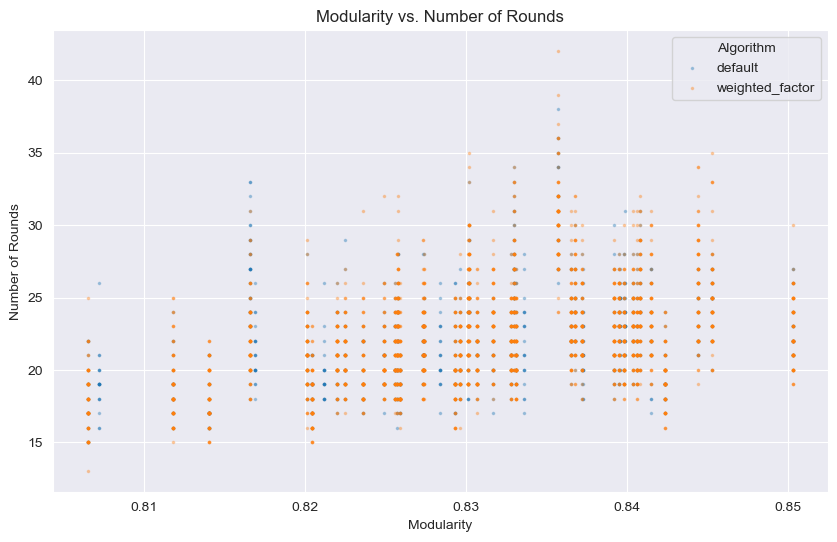

In [61]:
# Create a pretty plot using matplotlib
plt.figure(figsize=(10, 6))

for alg, df in alg_df.items():
    plt.scatter(df['modularity'], df['numRounds'], label=alg, alpha=0.3, marker='.', s=10)

plt.xlabel('Modularity')
plt.ylabel('Number of Rounds')
plt.title('Modularity vs. Number of Rounds')
plt.legend(title='Algorithm')

# Show the plot
plt.show()

In [62]:
# Group the DataFrame by 'factor'
group_by_factor = dataframe.groupby('factor')

# Create a dictionary to store the smaller DataFrames
grouped_df = {}

# Iterate over the groups and store them in the dictionary
for factor, group_df in group_by_factor:
    factor_key = f'{factor}'
    grouped_df[factor_key] = group_df
    print(f'Dataframe for weighted with factor {factor_key} has {len(group_df)} entries')

df_default = dataframe[dataframe['algorithm'] == 'default']
print(f'Dataframe for default has {len(df_default)} entries')

grouped_df.keys()

Dataframe for weighted with factor 1.25 has 400 entries
Dataframe for weighted with factor 1.5 has 400 entries
Dataframe for weighted with factor 1.75 has 400 entries
Dataframe for weighted with factor 2.0 has 400 entries
Dataframe for weighted with factor 2.25 has 400 entries
Dataframe for weighted with factor 2.5 has 400 entries
Dataframe for weighted with factor 2.75 has 400 entries
Dataframe for weighted with factor 3.0 has 400 entries
Dataframe for default has 1000 entries


dict_keys(['1.25', '1.5', '1.75', '2.0', '2.25', '2.5', '2.75', '3.0'])

In [78]:
# Define the exclusion list
exclusion_list = ['algorithm', 'factor', 'timestamp', 'objectStoragePath', 'graphType', 'numRounds']

copy_df = grouped_df['3.0'].copy()
# Create a list of unique combinations of the other columns for grouping
unique_combinations = copy_df.drop(exclusion_list, axis=1).drop_duplicates()

# Create an empty DataFrame to store the selected rows
selected_rows = pd.DataFrame(columns=dataframe.columns)

# Iterate over each unique combination
for _, combination in unique_combinations.iterrows():
    # Create a mask for selecting rows with the same values in the grouping columns
    mask = True
    for col, val in combination.items():
        mask &= dataframe[col] == val

    # Re-index the boolean series mask
    indexed_mask = mask.reindex(df_default.index)

    # Filter the DataFrame using the re-indexed mask
    default_subset = df_default[indexed_mask]

    # If the number of rows in the default subset is greater than 400, randomly select 400
    if len(default_subset) > 10:
        default_subset = default_subset.sample(n=10, random_state=42)  # You can change the random_state

    # Add the selected rows to the final DataFrame
    selected_rows = pd.concat([selected_rows, default_subset], ignore_index=True)

# Now 'selected_rows' contains the desired 400 rows
print(f"Final DataFrame has {len(selected_rows)} entries.")

Final DataFrame has 400 entries.


In [82]:
df_default_reduced = selected_rows
df_default_reduced

,timestamp,algorithm,assortativity,averageAuthorityScore,averageBetweennessCentrality,averageClosenessCentrality,averageCommunitySize,averageDegreeCentrality,averageEccentricity,averageEdgeDegree,...,stdevEigenvectorCentrality,stdevHubScore,stdevNearestNeighborsDegree,stdevPageRank,stdevRichClubCoefficient,transitivity,graphType,objectStoragePath,numRounds,factor
0,2023-07-13-13-20-26,default,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,2.340,...,0.0299,0.0029,0.6493,0.0003,0.0057,0.0077,real-network,gnutella-series-default-381233c6-dadf-41a9-9de...,19.0,NaN
1,2023-07-13-13-40-02,default,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,2.340,...,0.0299,0.0029,0.6493,0.0003,0.0057,0.0077,real-network,gnutella-series-default-381233c6-dadf-41a9-9de...,19.0,NaN
2,2023-07-13-13-33-20,default,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,2.340,...,0.0299,0.0029,0.6493,0.0003,0.0057,0.0077,real-network,gnutella-series-default-381233c6-dadf-41a9-9de...,22.0,NaN
3,2023-07-13-13-49-12,default,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,2.340,...,0.0299,0.0029,0.6493,0.0003,0.0057,0.0077,real-network,gnutella-series-default-381233c6-dadf-41a9-9de...,20.0,NaN
4,2023-07-13-14-13-01,default,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,2.340,...,0.0299,0.0029,0.6493,0.0003,0.0057,0.0077,real-network,gnutella-series-default-381233c6-dadf-41a9-9de...,21.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2023-07-15-12-39-15,default,0.2356,0.001,0.0108,0.0871,31.2500,0.0023,23.694,2.344,...,0.0310,0.0050,0.6679,0.0003,0.0124,0.0046,real-network,gnutella-series-default-381233c6-dadf-41a9-9de...,25.0,NaN
396,2023-07-15-11-58-27,default,0.2356,0.001,0.0108,0.0871,31.2500,0.0023,23.694,2.344,...,0.0310,0.0050,0.6679,0.0003,0.0124,0.0046,real-network,gnutella-series-default-381233c6-dadf-41a9-9de...,22.0,NaN
397,2023-07-15-12-31-56,default,0.2356,0.001,0.0108,0.0871,31.2500,0.0023,23.694,2.344,...,0.0310,0.0050,0.6679,0.0003,0.0124,0.0046,real-network,gnutella-series-default-381233c6-dadf-41a9-9de...,23.0,NaN
398,2023-07-15-12-18-38,default,0.2356,0.001,0.0108,0.0871,31.2500,0.0023,23.694,2.344,...,0.0310,0.0050,0.6679,0.0003,0.0124,0.0046,real-network,gnutella-series-default-381233c6-dadf-41a9-9de...,19.0,NaN


In [83]:
grouped_df['1.25']

,timestamp,algorithm,assortativity,averageAuthorityScore,averageBetweennessCentrality,averageClosenessCentrality,averageCommunitySize,averageDegreeCentrality,averageEccentricity,averageEdgeDegree,...,stdevEigenvectorCentrality,stdevHubScore,stdevNearestNeighborsDegree,stdevPageRank,stdevRichClubCoefficient,transitivity,graphType,objectStoragePath,numRounds,factor
1000,2023-07-16-14-12-04,weighted_factor,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,2.340,...,0.0299,0.0029,0.6493,0.0003,0.0057,0.0077,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,19.0,1.25
1001,2023-07-16-14-39-18,weighted_factor,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,2.340,...,0.0299,0.0029,0.6493,0.0003,0.0057,0.0077,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,19.0,1.25
1002,2023-07-16-14-14-50,weighted_factor,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,2.340,...,0.0299,0.0029,0.6493,0.0003,0.0057,0.0077,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,18.0,1.25
1003,2023-07-16-14-17-36,weighted_factor,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,2.340,...,0.0299,0.0029,0.6493,0.0003,0.0057,0.0077,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,18.0,1.25
1004,2023-07-16-14-20-52,weighted_factor,0.1515,0.001,0.0109,0.0862,32.2581,0.0023,23.192,2.340,...,0.0299,0.0029,0.6493,0.0003,0.0057,0.0077,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,21.0,1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4125,2023-07-24-06-09-46,weighted_factor,0.2356,0.001,0.0108,0.0871,31.2500,0.0023,23.694,2.344,...,0.0310,0.0050,0.6679,0.0003,0.0124,0.0046,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,22.0,1.25
4126,2023-07-24-06-12-57,weighted_factor,0.2356,0.001,0.0108,0.0871,31.2500,0.0023,23.694,2.344,...,0.0310,0.0050,0.6679,0.0003,0.0124,0.0046,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,18.0,1.25
4127,2023-07-24-06-16-00,weighted_factor,0.2356,0.001,0.0108,0.0871,31.2500,0.0023,23.694,2.344,...,0.0310,0.0050,0.6679,0.0003,0.0124,0.0046,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,20.0,1.25
4128,2023-07-24-06-19-06,weighted_factor,0.2356,0.001,0.0108,0.0871,31.2500,0.0023,23.694,2.344,...,0.0310,0.0050,0.6679,0.0003,0.0124,0.0046,real-network,gnutella-series-weighted-factor-0ccd0dc8-7060-...,20.0,1.25


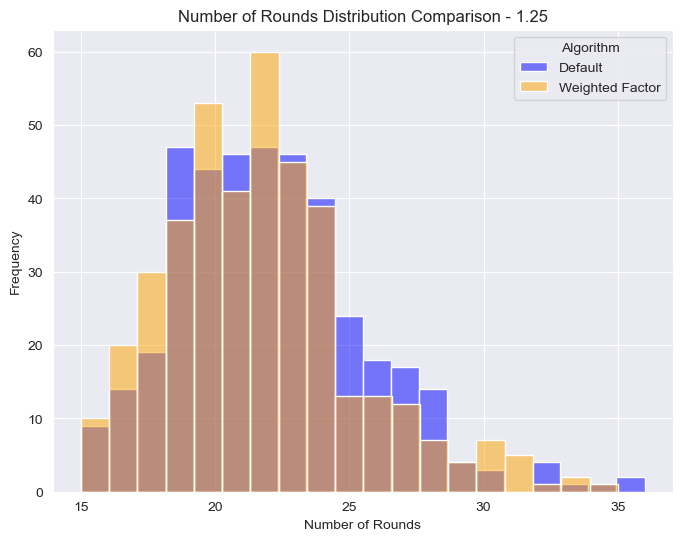

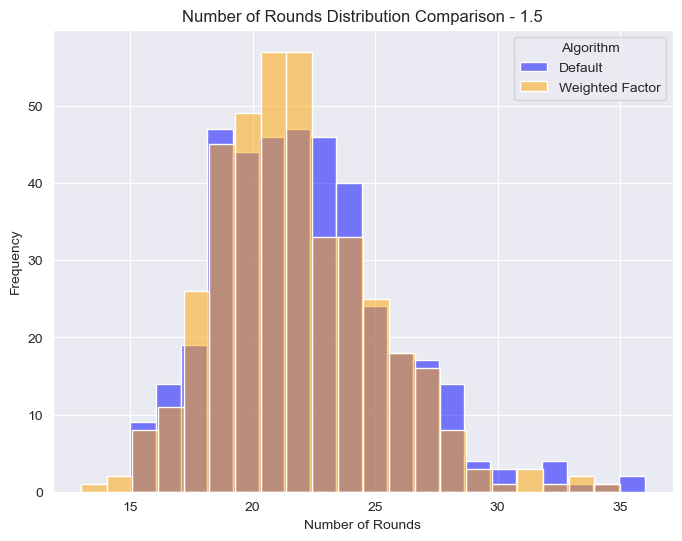

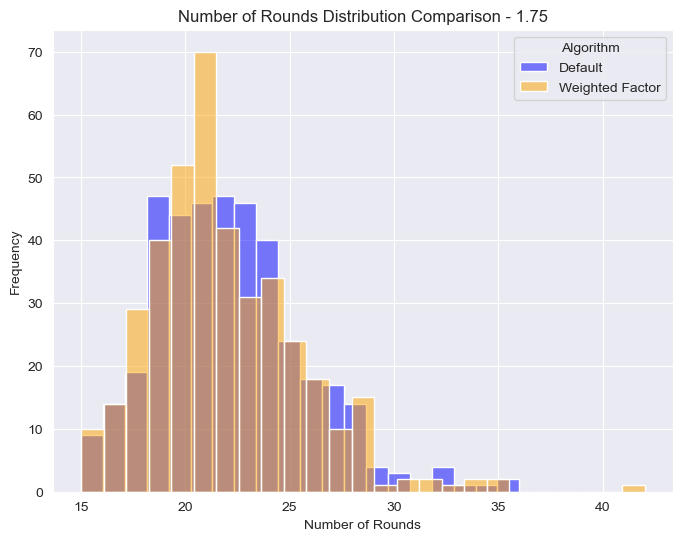

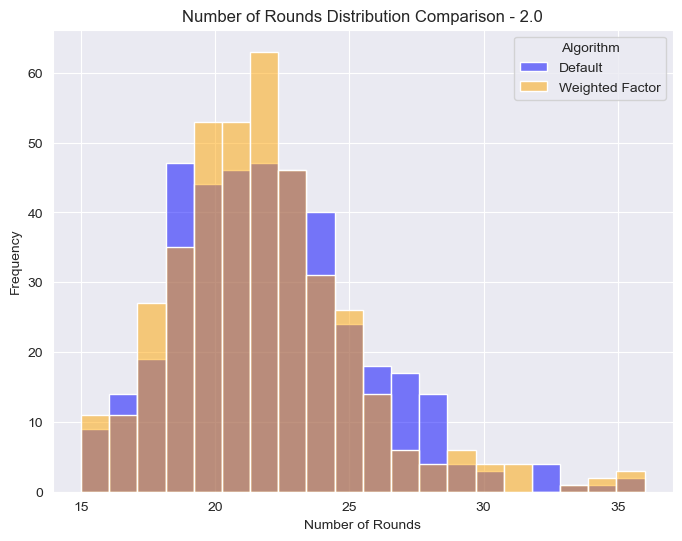

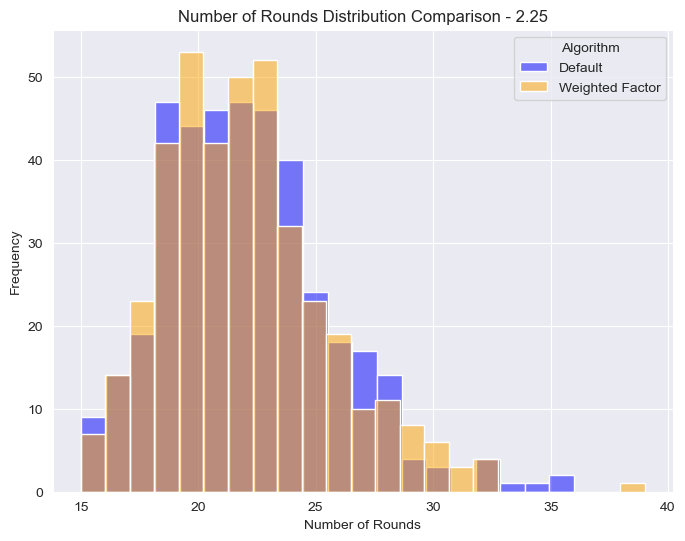

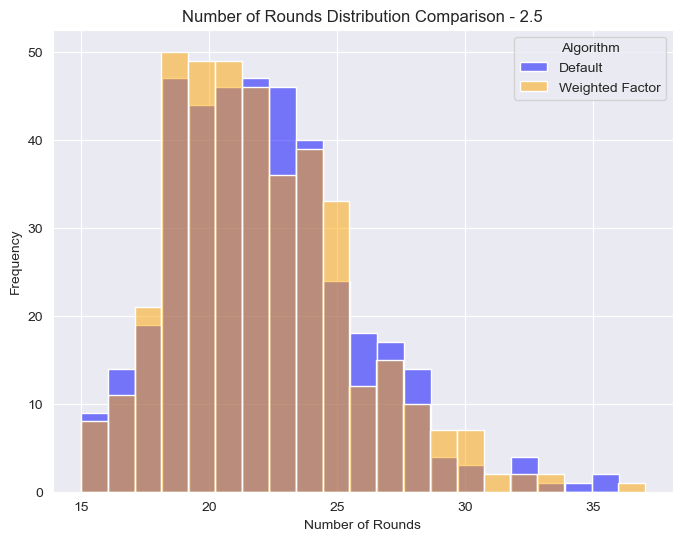

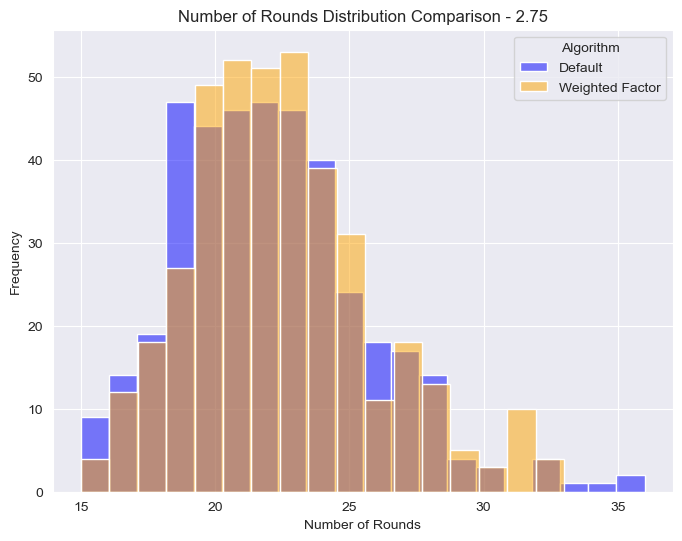

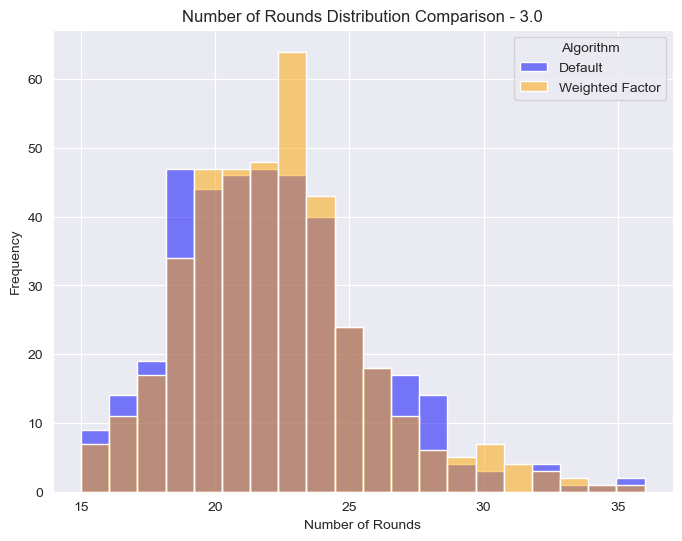

In [84]:
# Sort the grouped DataFrame keys
sorted_keys = sorted(grouped_df.keys())

# Iterate over the sorted grouped keys and create separate plots
for idx, group_key in enumerate(sorted_keys):
    # Get the DataFrame for the current key
    group_df = grouped_df[group_key]

    # Create a new plot for each rounded modularity combination
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df_default_reduced, x='numRounds', label='Default', color='blue', alpha=0.5)
    sns.histplot(data=group_df, x='numRounds', label='Weighted Factor', color='orange', alpha=0.5)

    plt.xlabel('Number of Rounds')
    plt.ylabel('Frequency')
    plt.title(f'Number of Rounds Distribution Comparison - {group_key}')
    plt.legend(title='Algorithm')

    # Show the plot
    plt.show()

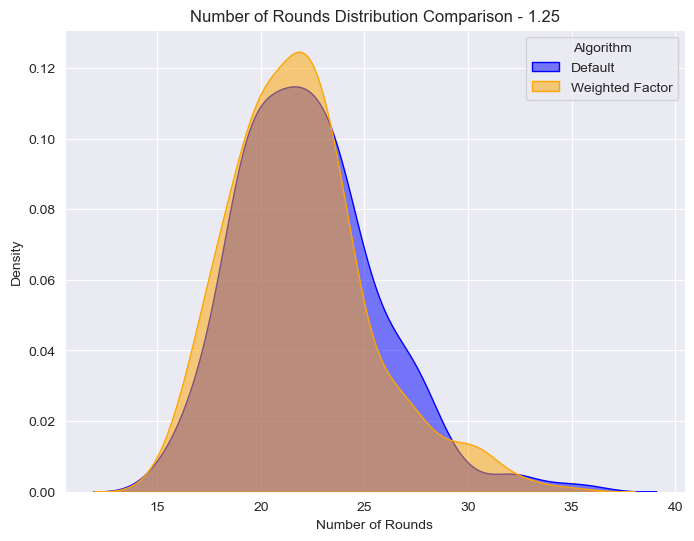

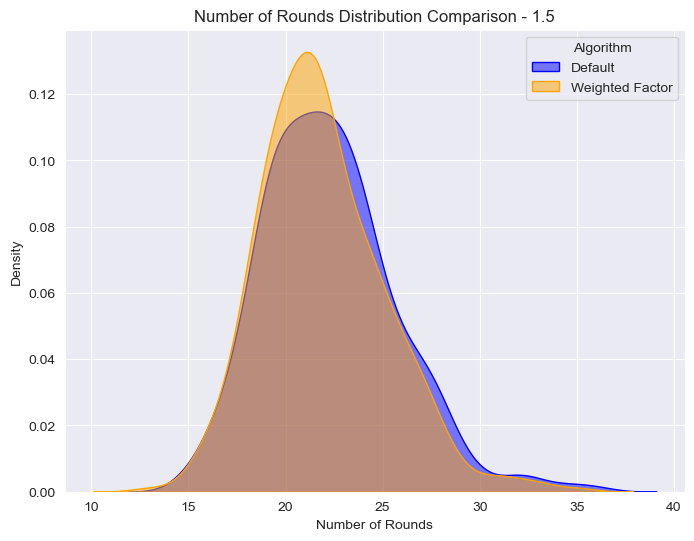

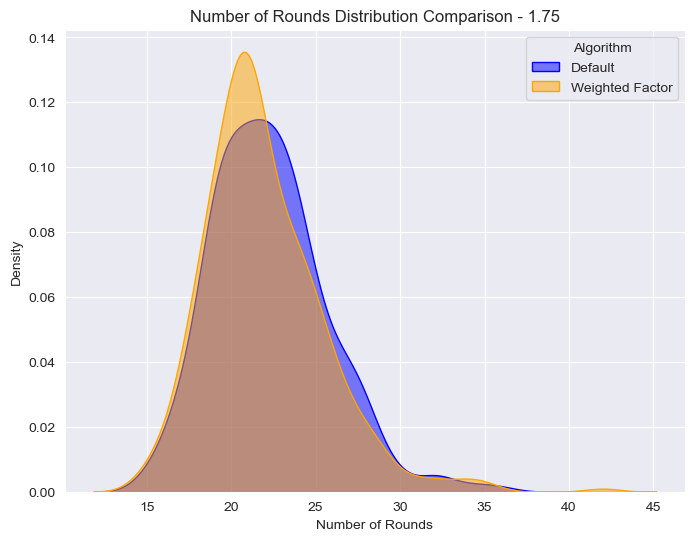

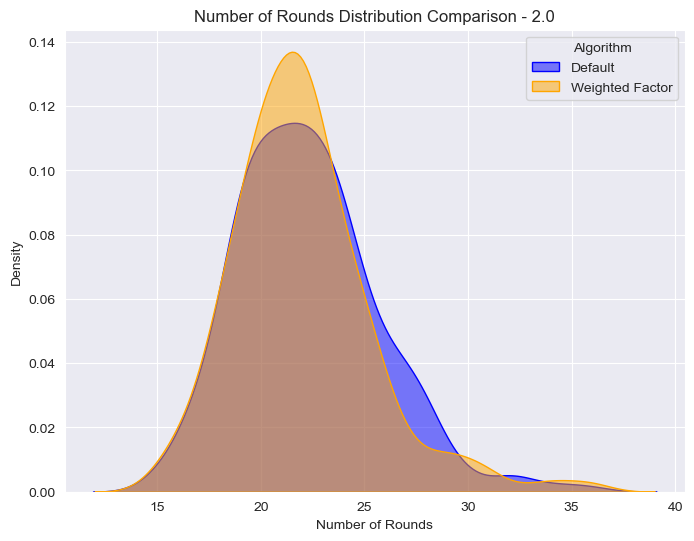

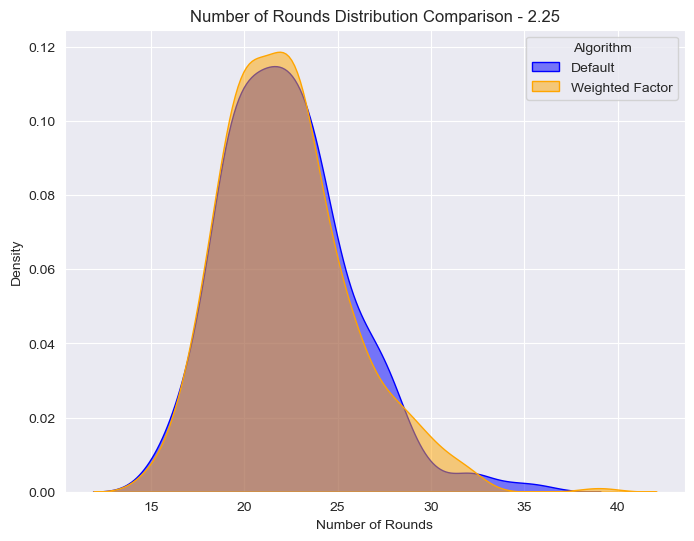

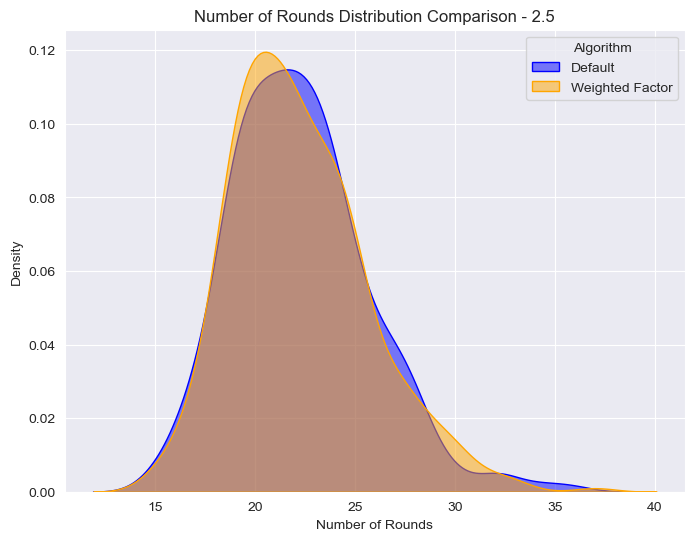

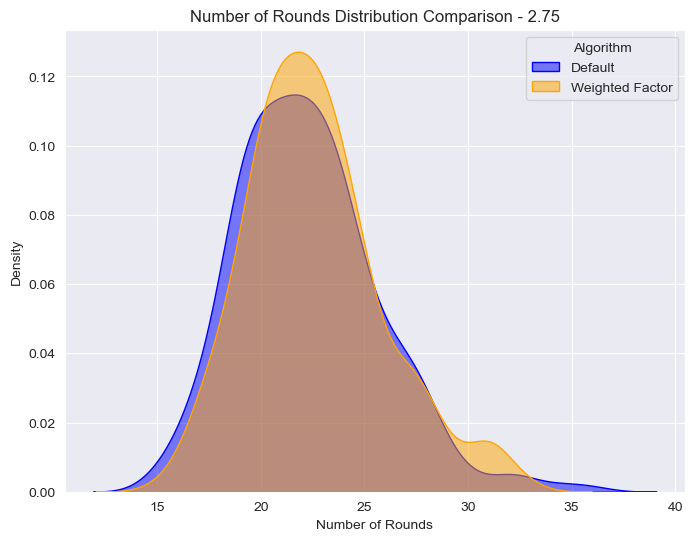

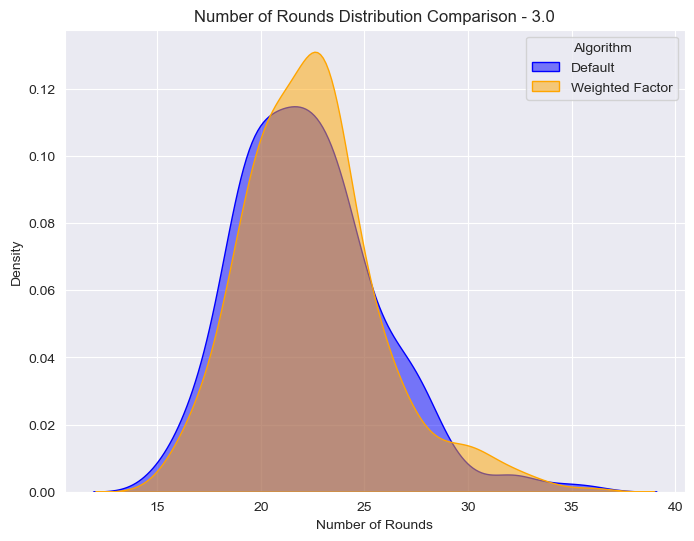

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the grouped DataFrame keys
sorted_keys = sorted(grouped_df.keys())

# Iterate over the sorted grouped keys and create separate plots
for idx, group_key in enumerate(sorted_keys):
    # Get the DataFrame for the current key
    group_df = grouped_df[group_key]

    # Split the DataFrame into default and weighted_factor data
    default_data = group_df[group_df['algorithm'] == 'default']
    weighted_factor_data = group_df[group_df['algorithm'] == 'weighted_factor']

    # Create a new plot for each rounded modularity combination
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data=df_default_reduced, x='numRounds', label='Default', color='blue', fill=True, alpha=0.5)
    sns.kdeplot(data=weighted_factor_data, x='numRounds', label='Weighted Factor', color='orange', fill=True, alpha=0.5)

    plt.xlabel('Number of Rounds')
    plt.ylabel('Density')
    plt.title(f'Number of Rounds Distribution Comparison - {group_key}')
    plt.legend(title='Algorithm')

    # Show the plot
    plt.show()

In [86]:
def print_performance_difference(df1, df2, text1, text2):
    # Calculate the total number of rounds for the two dataframes
    total_rounds_df1 = df1['numRounds'].sum()
    total_rounds_df2 = df2['numRounds'].sum()

    # Calculate the percentage change
    percentage_change = ((total_rounds_df1 - total_rounds_df2) / total_rounds_df2) * 100

    print(f"The {text1} algorithm is {abs(percentage_change):.2f}% {'faster' if percentage_change < 0 else 'slower'} than the {text2} algorithm.")

In [87]:
for factor, df in grouped_df.items():
    print_performance_difference(df, df_default_reduced, f'Weighted factor ({factor})', 'default')

The Weighted factor (1.25) algorithm is 1.72% faster than the default algorithm.
The Weighted factor (1.5) algorithm is 1.66% faster than the default algorithm.
The Weighted factor (1.75) algorithm is 1.47% faster than the default algorithm.
The Weighted factor (2.0) algorithm is 1.31% faster than the default algorithm.
The Weighted factor (2.25) algorithm is 0.21% faster than the default algorithm.
The Weighted factor (2.5) algorithm is 0.16% faster than the default algorithm.
The Weighted factor (2.75) algorithm is 1.52% slower than the default algorithm.
The Weighted factor (3.0) algorithm is 0.88% slower than the default algorithm.


In [88]:
def plot_correlation_matrices(dataframe, text):
    # Compute correlations between numerical columns and 'numRounds'
    correlation_matrix = dataframe.corr(numeric_only=True)

    # Filter out non-numerical columns, timestamps, and text value columns
    numerical_columns = correlation_matrix.columns[(correlation_matrix.dtypes != 'object')
                        & (correlation_matrix.columns != 'numRounds')]

    # Filter columns where correlation values are greater than 0 and not NaN or empty
    valid_numerical_columns = [col for col in numerical_columns if
                               correlation_matrix.loc['numRounds', col] > 0 or
                               correlation_matrix.loc['numRounds', col] < 0 and
                               not pd.isnull(correlation_matrix.loc['numRounds', col])]

     # Plot correlation values
    plt.figure(figsize=(15, 6))  # Increase figure size to avoid x-axis overlap
    sns.barplot(x=valid_numerical_columns, y=correlation_matrix.loc['numRounds', valid_numerical_columns])
    plt.xticks(rotation=45, ha='right')  # Adjust x-axis labels rotation and alignment
    plt.xlabel('Columns')
    plt.ylabel('Correlation with numRounds')
    plt.title(f'Correlation of Columns with numRounds for {text}')
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Sort columns based on absolute correlation values with 'numRounds'
    sorted_columns = sorted(valid_numerical_columns,
                            key=lambda col: abs(correlation_matrix.loc['numRounds', col]),
                            reverse=True)

    # Select the top 10 columns with the highest correlation values
    top_columns = sorted_columns[:10]

    # Plot correlation values
    plt.figure(figsize=(6, 6))  # Increase figure size to avoid x-axis overlap
    sns.barplot(x=top_columns, y=correlation_matrix.loc['numRounds', top_columns])
    plt.xticks(rotation=45, ha='right')  # Adjust x-axis labels rotation and alignment
    plt.xlabel('Columns')
    plt.ylabel('Correlation with numRounds')
    plt.title(f'Correlation of Columns with numRounds for {text}')
    plt.tight_layout()

    # Show the plot
    plt.show()

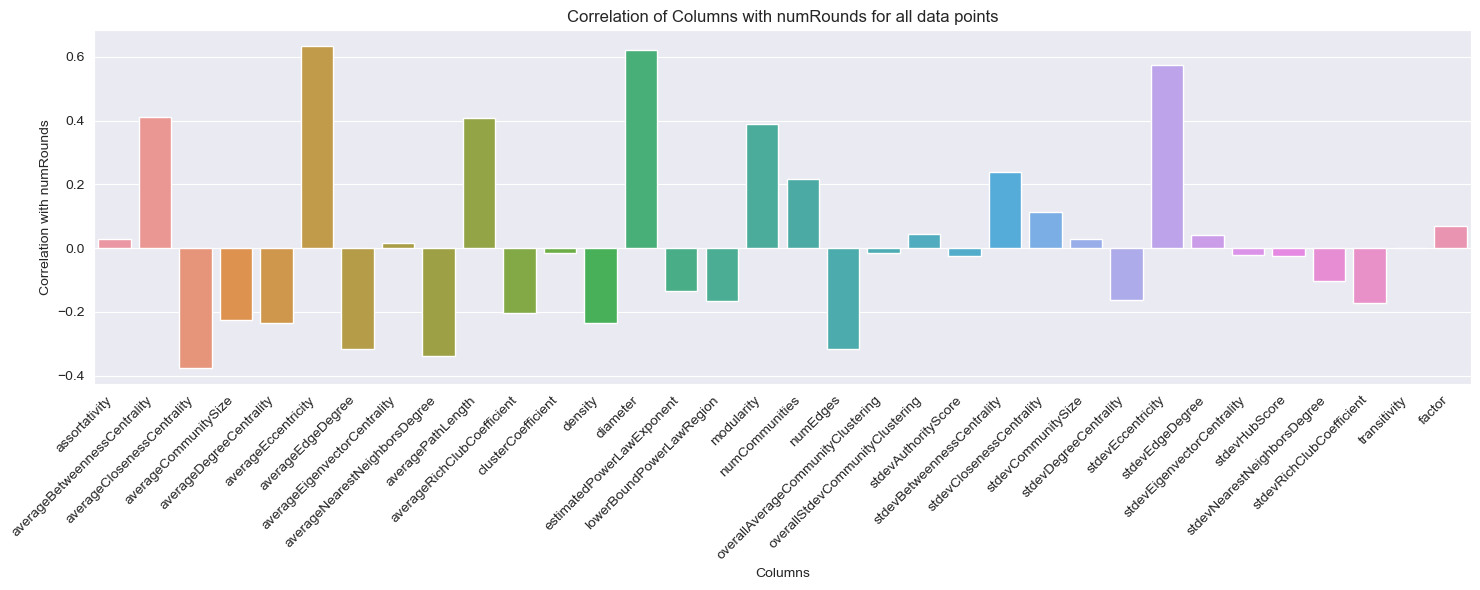

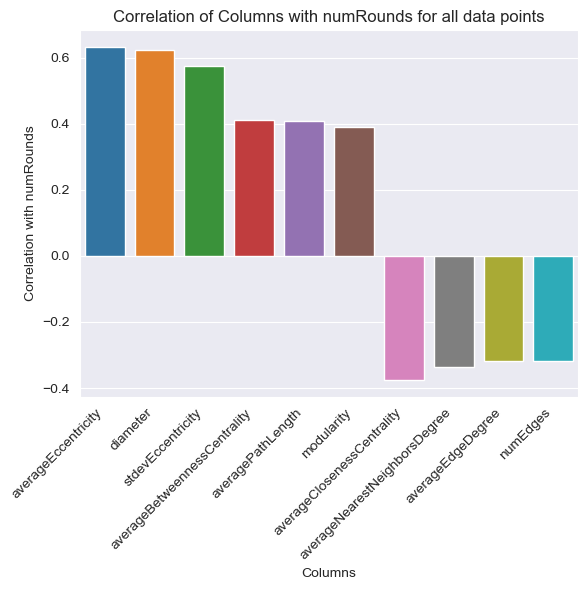

In [89]:
plot_correlation_matrices(dataframe, 'all data points')

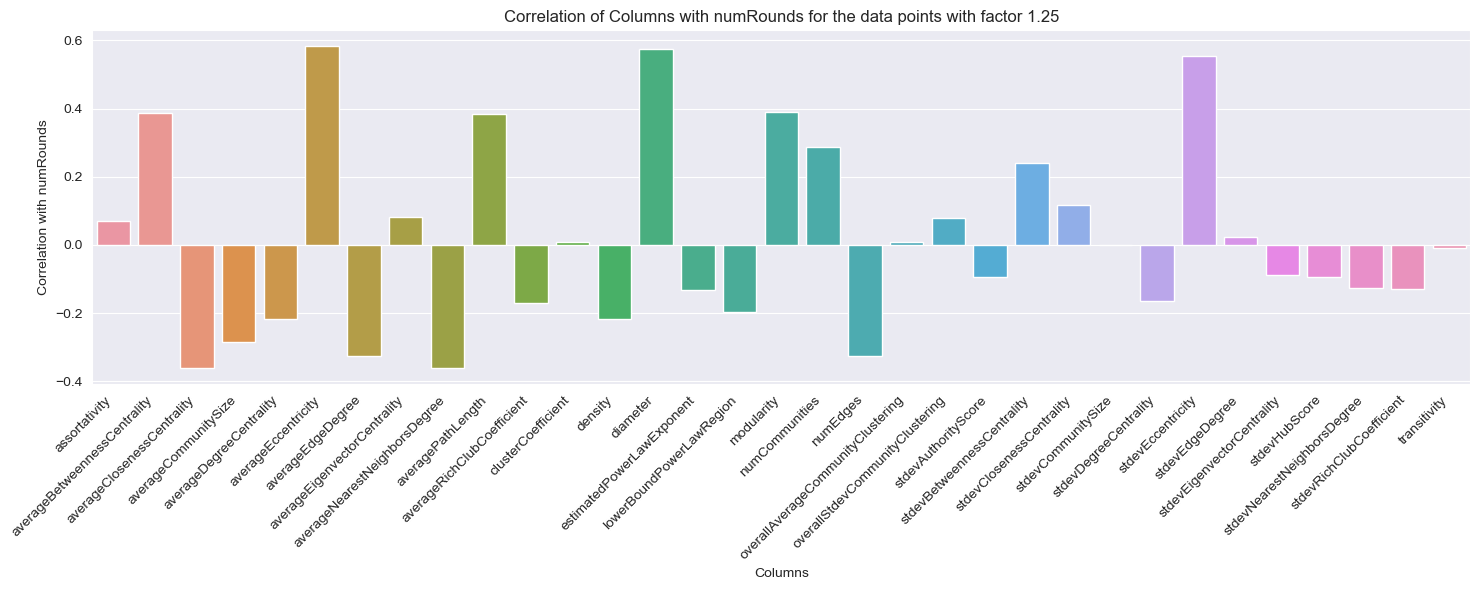

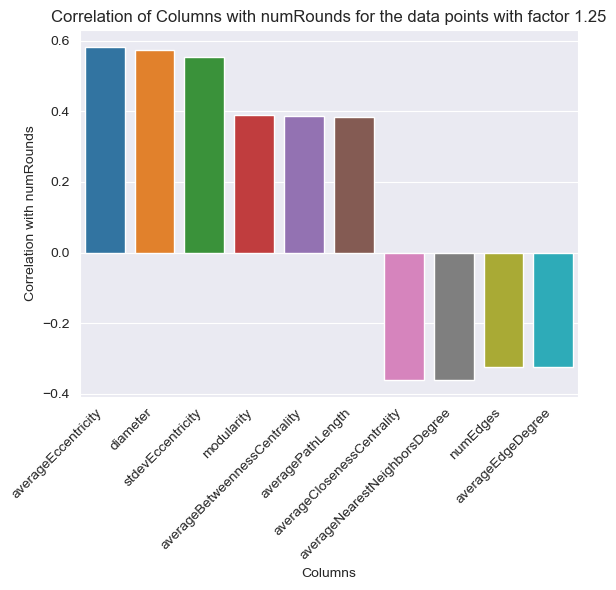

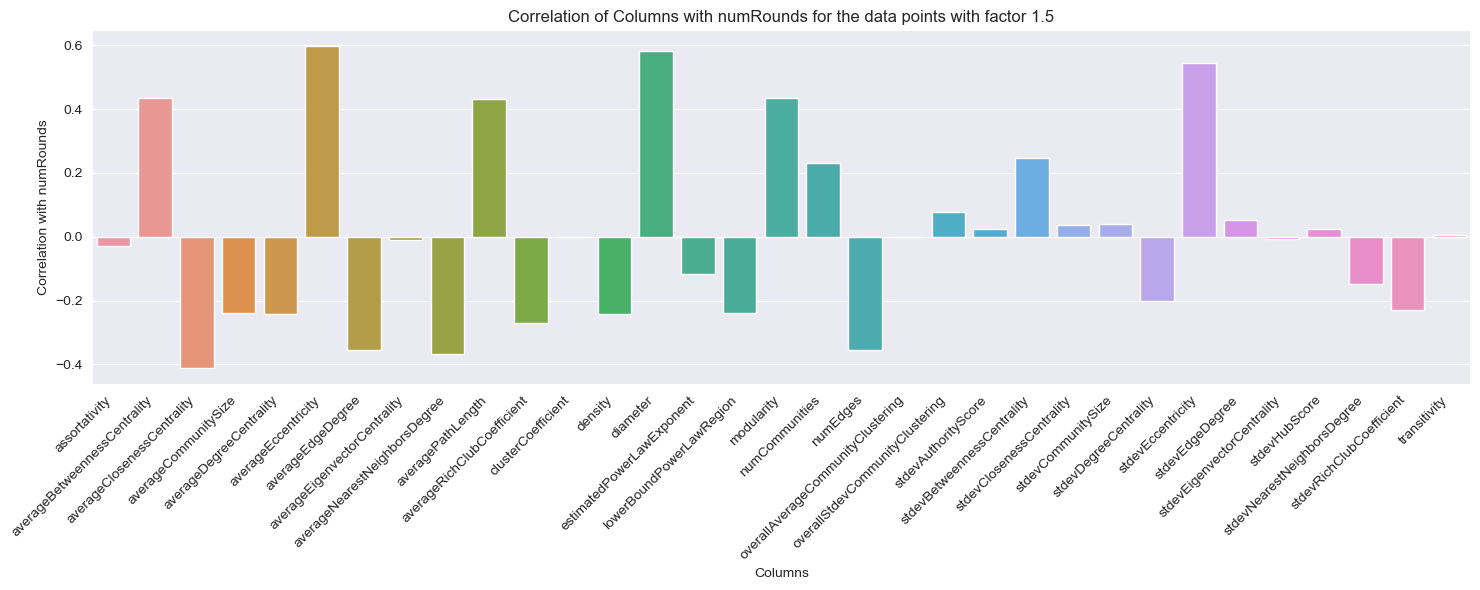

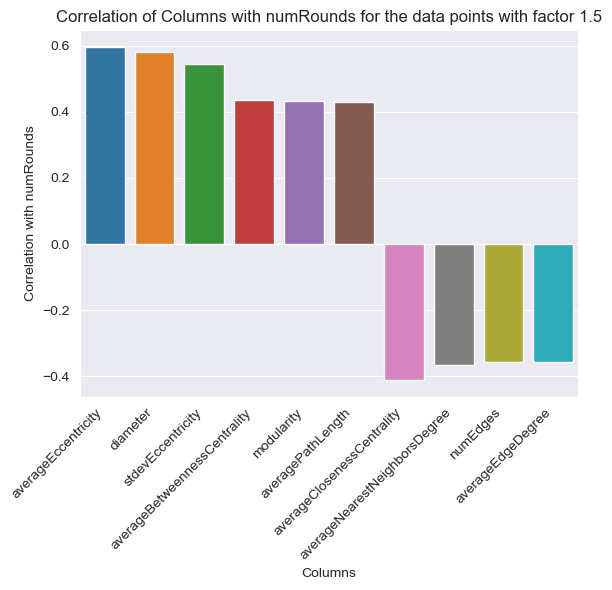

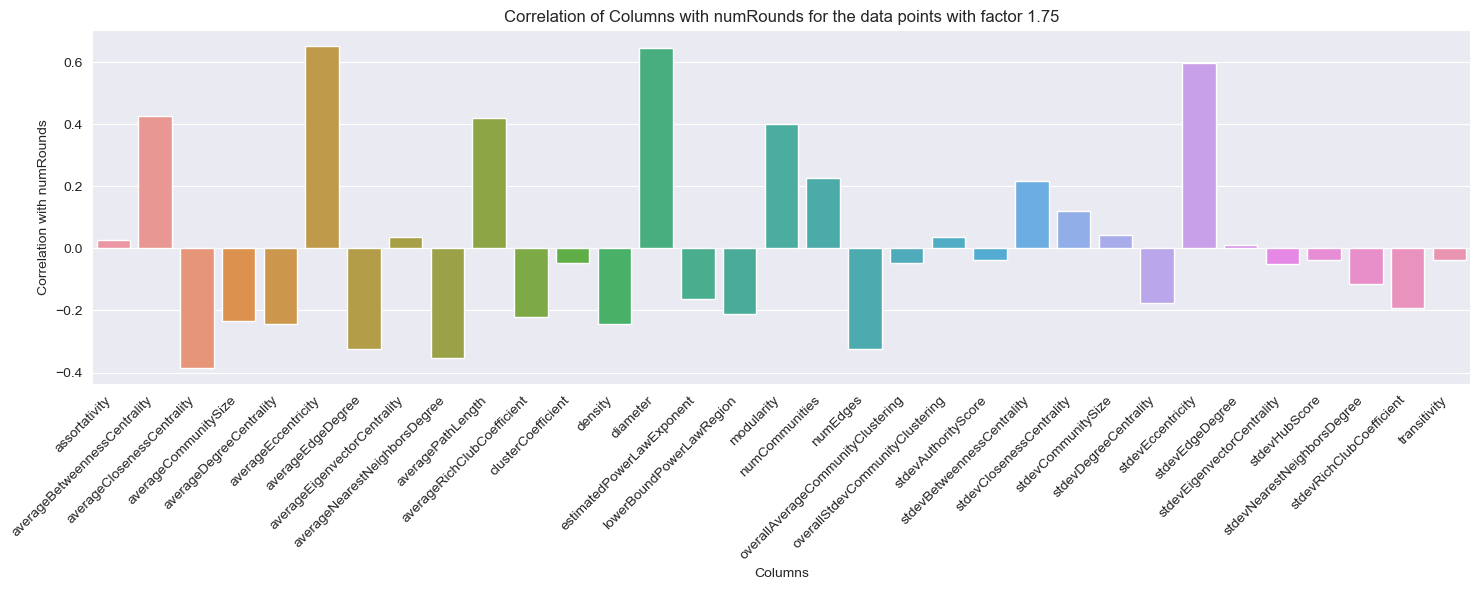

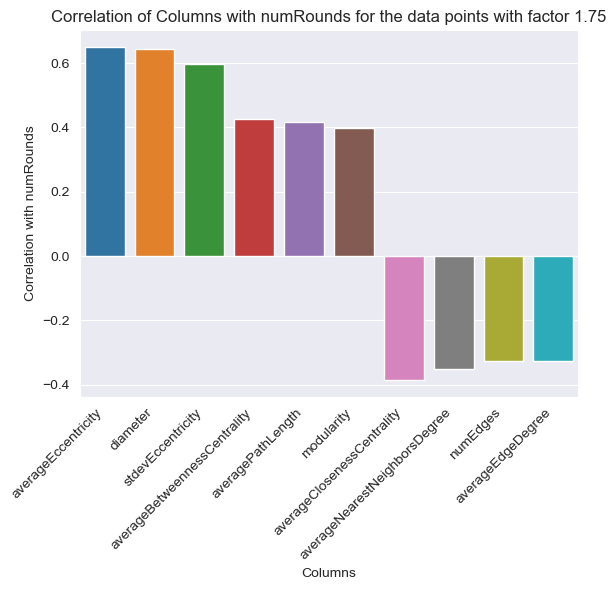

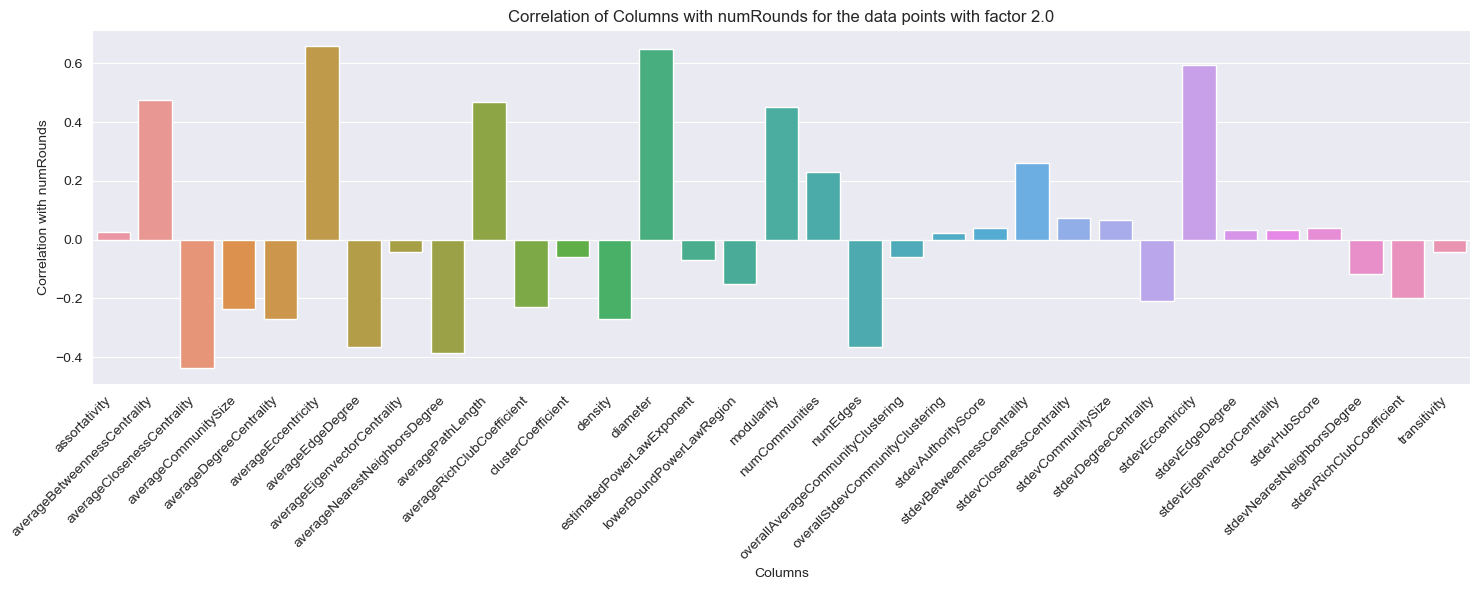

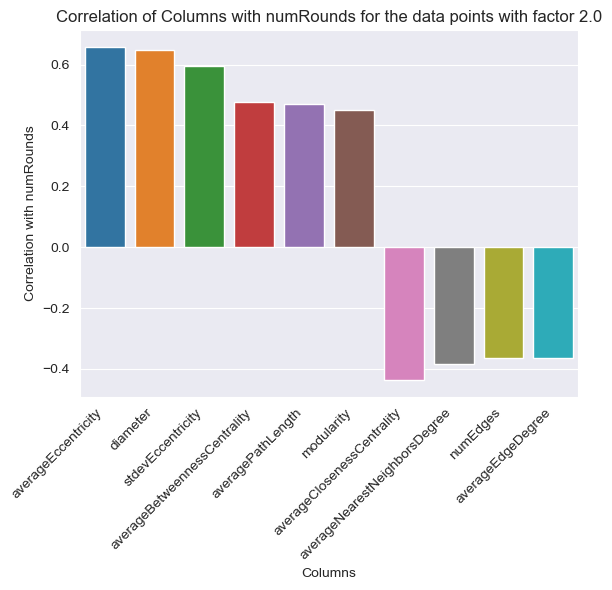

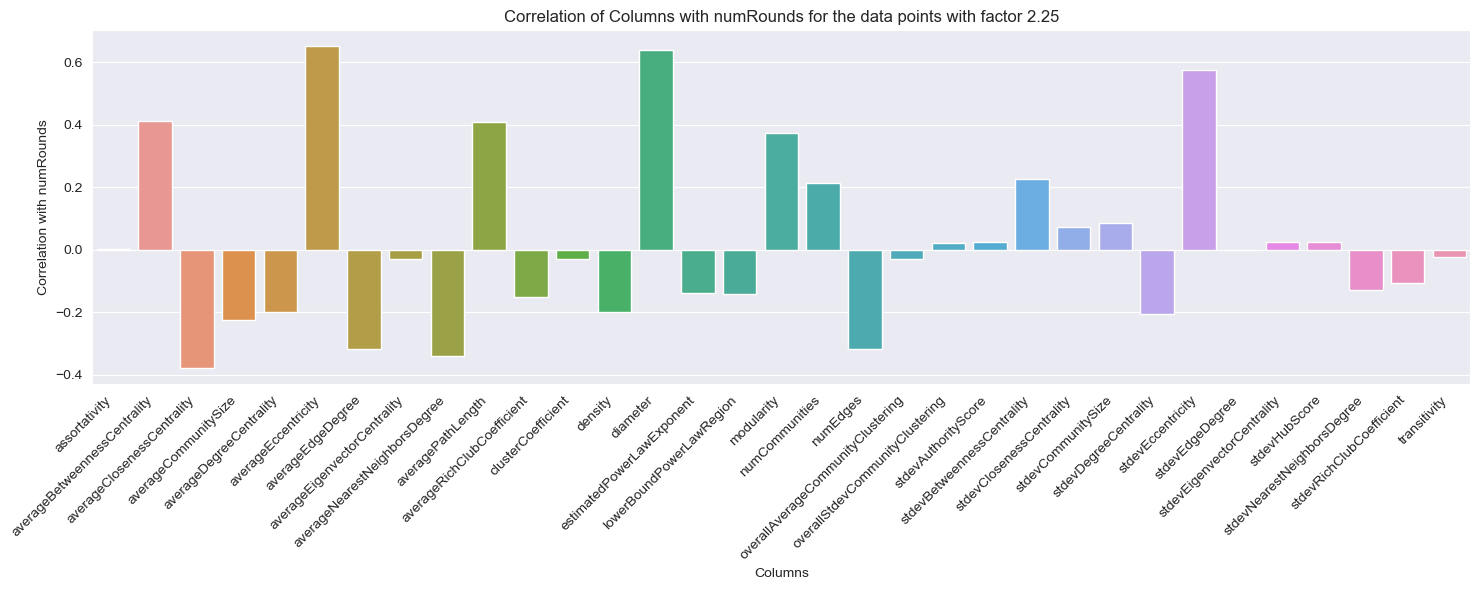

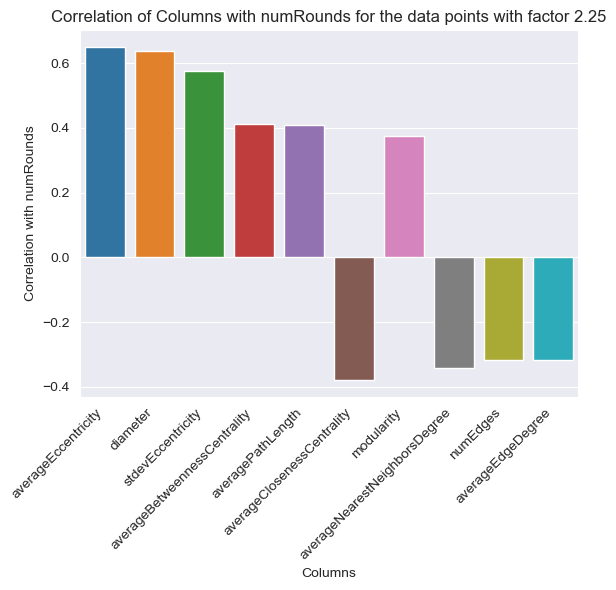

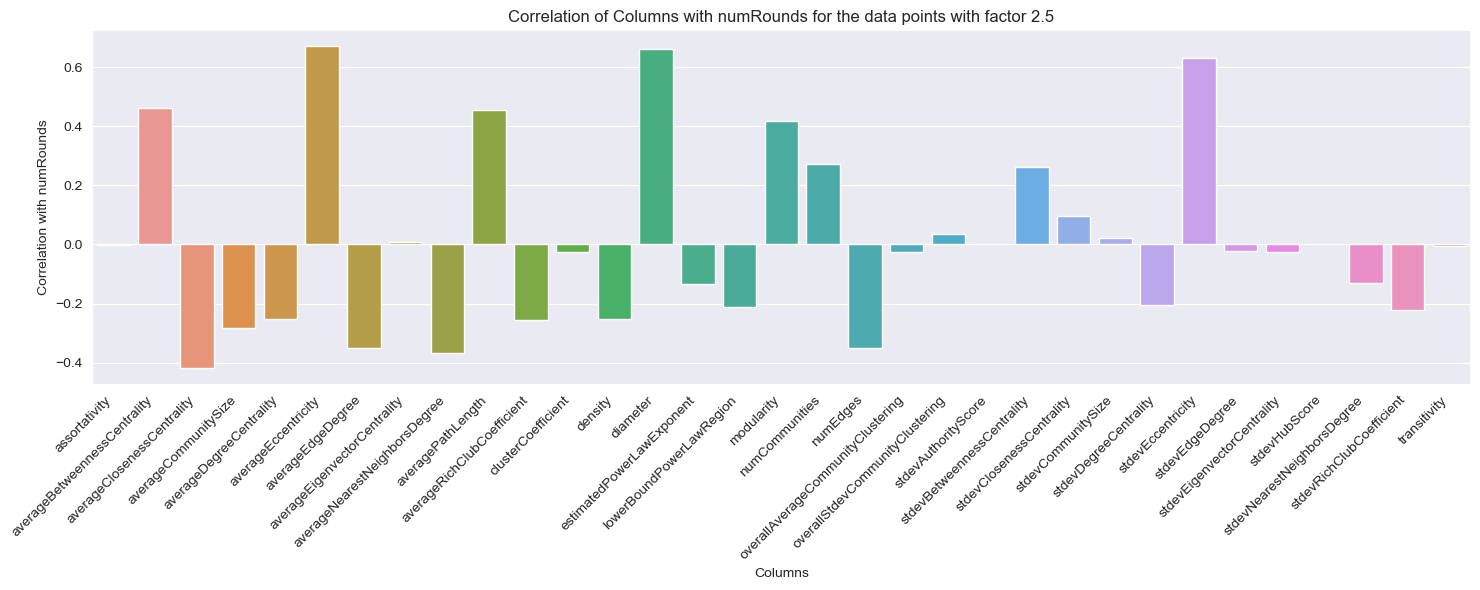

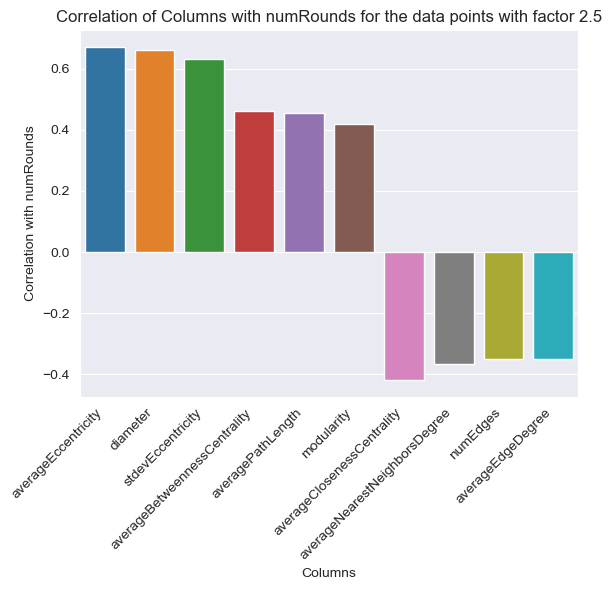

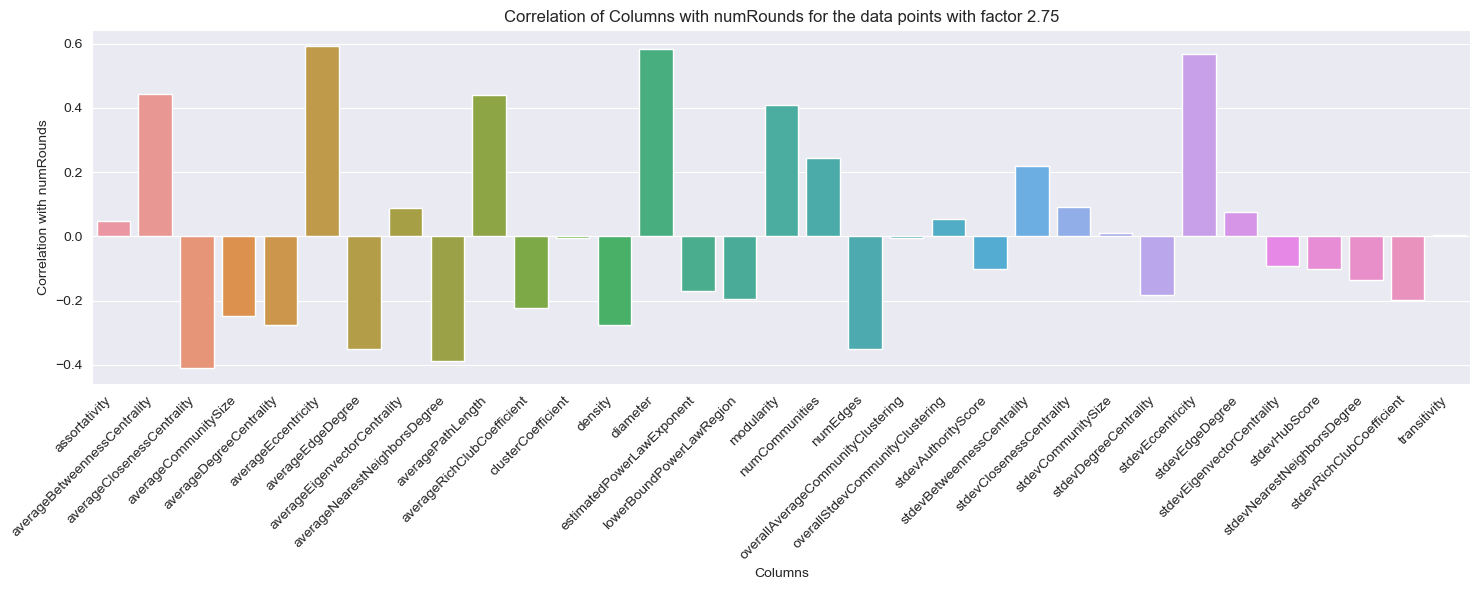

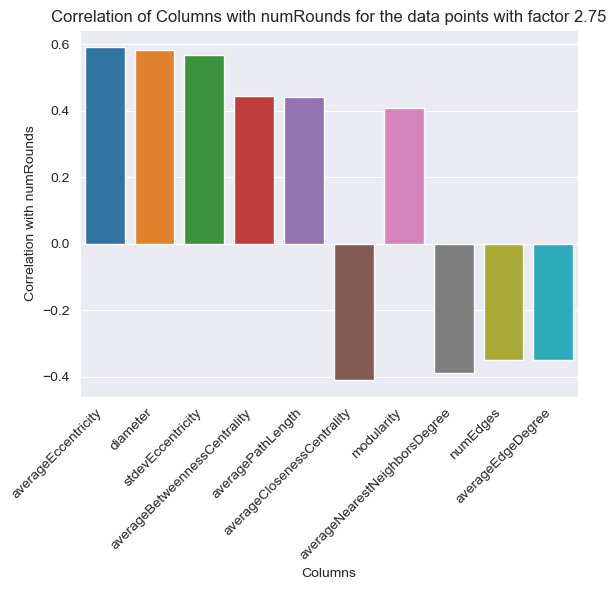

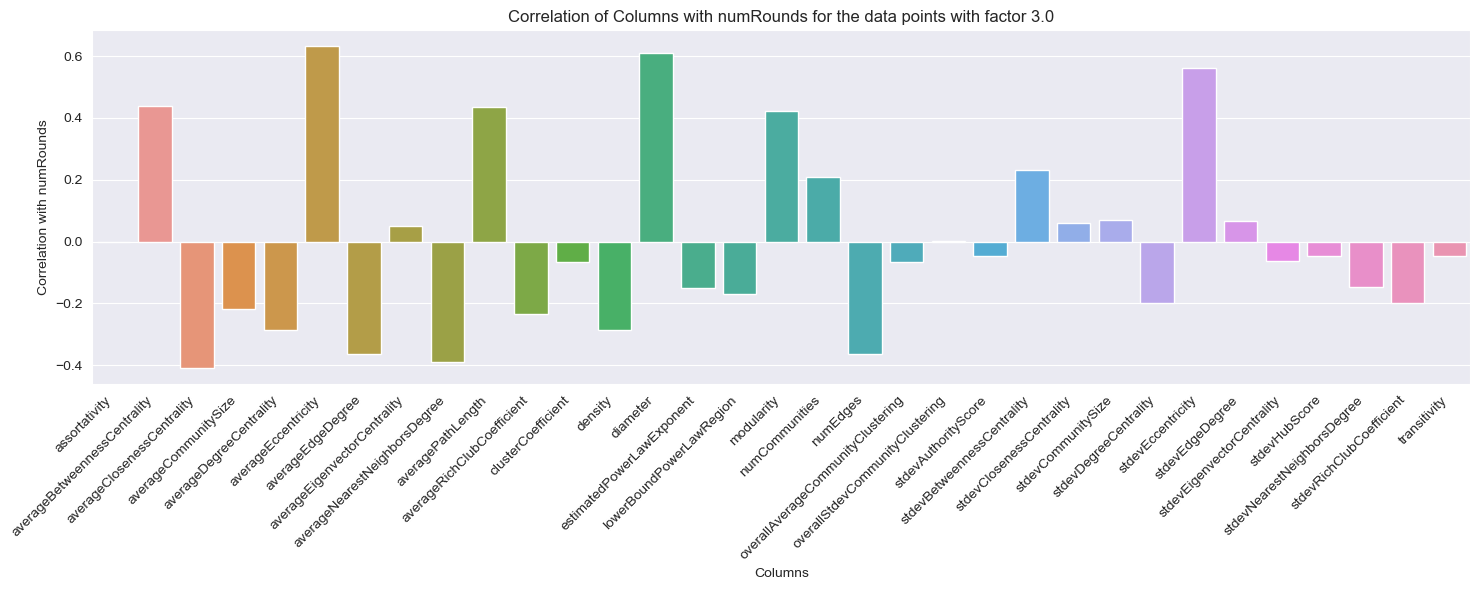

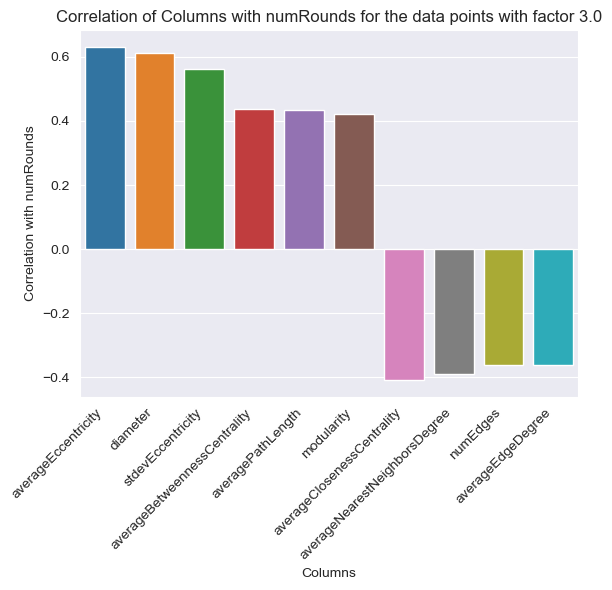

In [90]:
for factor, df in grouped_df.items():
    plot_correlation_matrices(df, f'the data points with factor {factor}')